# ***`LAB04.01`***

Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
Nhập lựa chọn (1-2): 2
=== Bắt đầu thử nghiệm ===

=== Phân tích mạng ===
Số lượng node: 77
Số lượng cạnh: 254
Hệ số clustering trung bình: 0.573


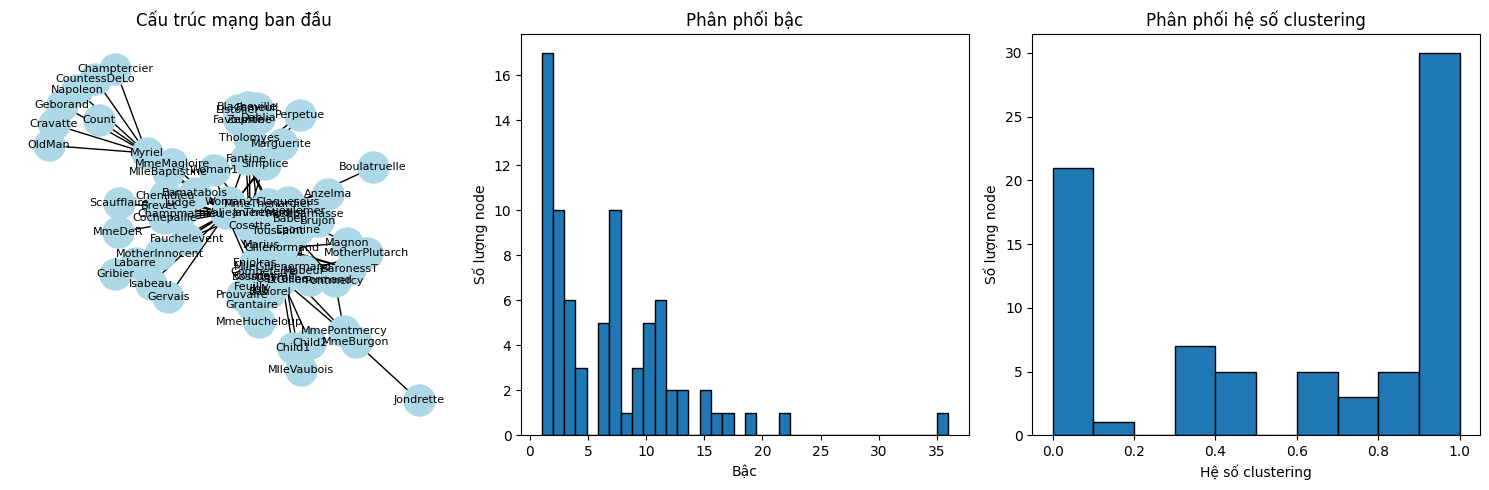


=== Thông tin về tập dữ liệu ===
Tổng số cạnh ban đầu: 254
Số cạnh train: 203
Số cạnh test (cạnh sẽ xuất hiện): 51
Số cặp node test không có cạnh: 51


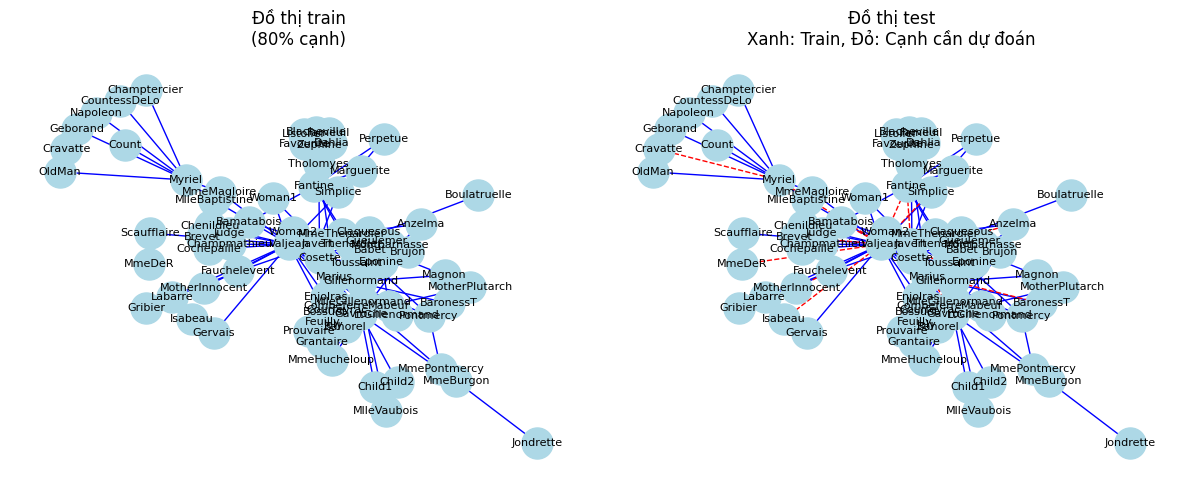


=== Đánh giá các phương pháp ===


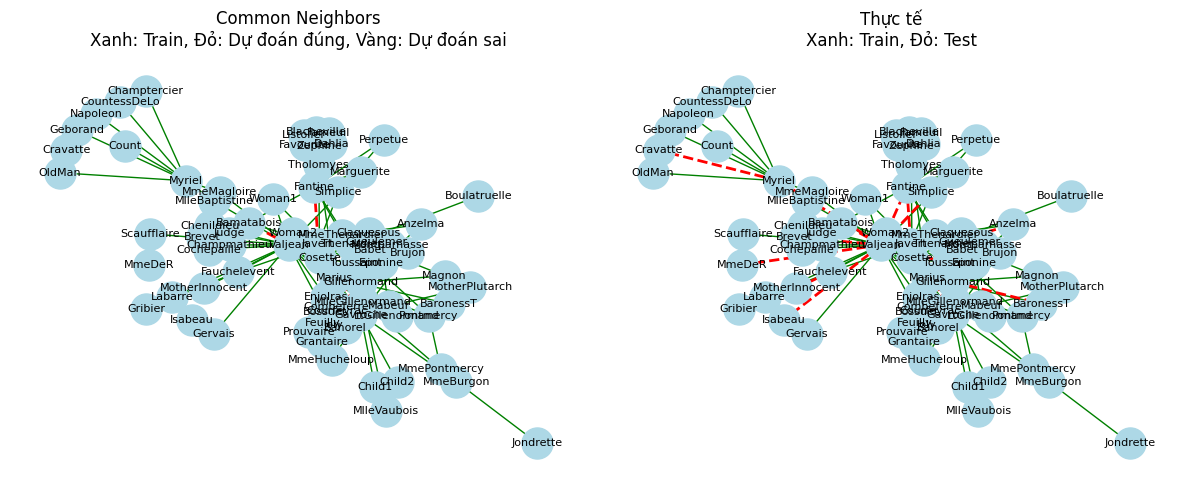

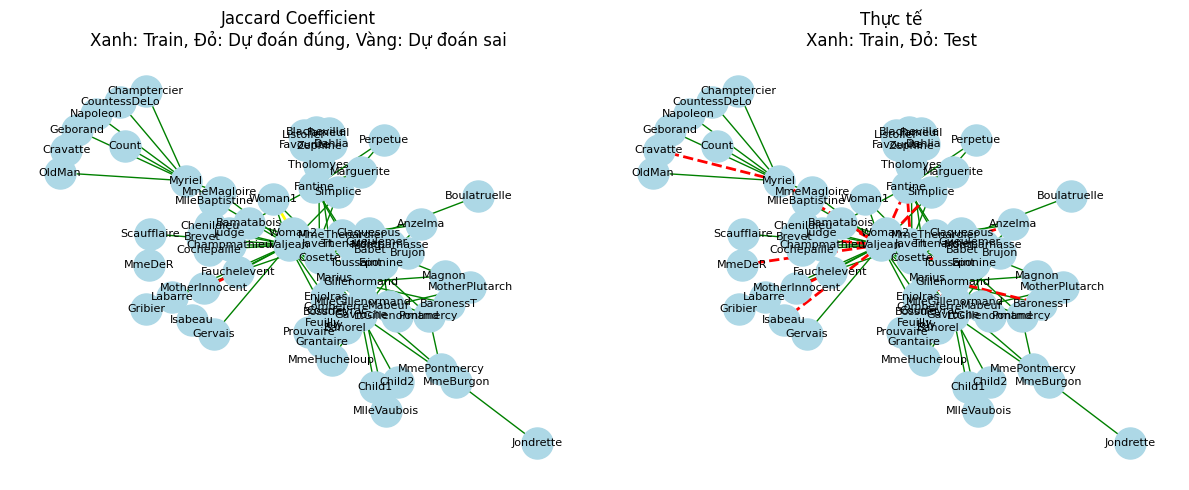

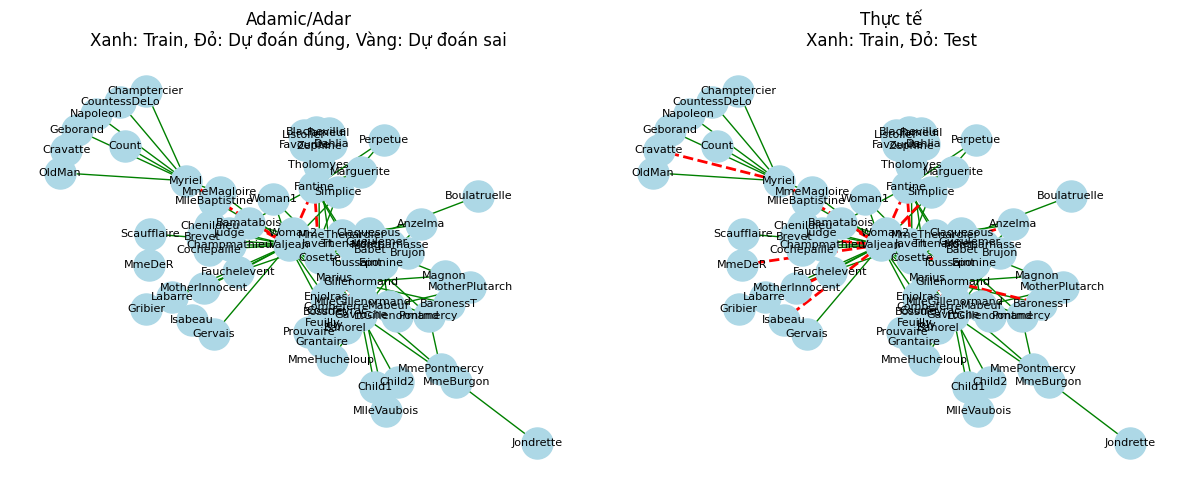

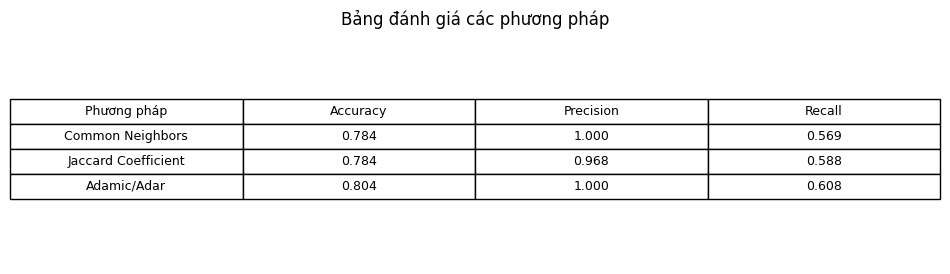

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với lựa chọn dataset.

        Parameters:
            dataset (str): Tên dataset ('karate', 'davis', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số lượng node: {self.G.number_of_nodes()}")
        print(f"Số lượng cạnh: {self.G.number_of_edges()}")
        print(f"Hệ số clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))

        # Vẽ cấu trúc mạng ban đầu
        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8)
        plt.title("Cấu trúc mạng ban đầu")

        # Vẽ phân phối bậc
        plt.subplot(132)
        degrees = [d for n, d in self.G.degree()]
        plt.hist(degrees, bins=max(degrees)-min(degrees)+1, edgecolor='black')
        plt.title("Phân phối bậc")
        plt.xlabel("Bậc")
        plt.ylabel("Số lượng node")

        # Vẽ phân phối hệ số clustering
        plt.subplot(133)
        clustering_coeffs = list(nx.clustering(self.G).values())
        plt.hist(clustering_coeffs, bins=10, edgecolor='black')
        plt.title("Phân phối hệ số clustering")
        plt.xlabel("Hệ số clustering")
        plt.ylabel("Số lượng node")

        plt.tight_layout()
        plt.show()

    def prepare_data(self):
        """
        Chuẩn bị dữ liệu bằng cách giả lập dự đoán tương lai:
        1. Ẩn 20% cạnh hiện có (tập test) - giả sử đây là các liên kết sẽ xuất hiện trong tương lai
        2. Sử dụng 80% cạnh còn lại (tập train) để học và dự đoán
        """
        # Copy đồ thị gốc để giữ lại thông tin đầy đủ
        self.original_G = self.G.copy()

        # 1. Chia cạnh thành train/test
        all_edges = list(self.G.edges())
        train_edges, test_edges = train_test_split(all_edges, test_size=0.2, random_state=42)

        # 2. Tạo đồ thị train bằng cách xóa các cạnh test
        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(test_edges)

        # 3. Lấy các cặp node không có cạnh từ đồ thị train
        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        test_non_edges = non_edges[:len(test_edges)]

        # Lưu lại để sử dụng
        self.train_edges = train_edges
        self.test_edges = test_edges        # Các cạnh thật sự sẽ xuất hiện
        self.test_non_edges = test_non_edges  # Các cạnh thật sự không xuất hiện

        print("\n=== Thông tin về tập dữ liệu ===")
        print(f"Tổng số cạnh ban đầu: {len(all_edges)}")
        print(f"Số cạnh train: {len(train_edges)}")
        print(f"Số cạnh test (cạnh sẽ xuất hiện): {len(test_edges)}")
        print(f"Số cặp node test không có cạnh: {len(test_non_edges)}")

        # Vẽ đồ thị train và test
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(self.original_G, seed=42)

        plt.subplot(121)
        nx.draw(self.train_G, pos, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=500, font_size=8)
        plt.title("Đồ thị train\n(80% cạnh)")

        plt.subplot(122)
        nx.draw(self.train_G, pos, with_labels=True, node_color='lightblue',
                edge_color='blue', node_size=500, font_size=8)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=test_edges,
                             edge_color='red', style='dashed')
        plt.title("Đồ thị test\nXanh: Train, Đỏ: Cạnh cần dự đoán")

        plt.tight_layout()
        plt.show()

    def common_neighbors_score(self, u, v):
        """Tính điểm dựa trên số lượng láng giềng chung."""
        return len(list(nx.common_neighbors(self.train_G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """Tính hệ số Jaccard."""
        neighbors_u = set(self.train_G.neighbors(u))
        neighbors_v = set(self.train_G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """Tính chỉ số Adamic/Adar."""
        return sum(1 / np.log(self.train_G.degree(w))
                  for w in nx.common_neighbors(self.train_G, u, v))

    def extract_features(self, edge_list):
        """Trích xuất đặc trưng cho các cạnh."""
        features = []
        for u, v in edge_list:
            features.append([
                self.common_neighbors_score(u, v),
                self.jaccard_coefficient_score(u, v),
                self.adamic_adar_score(u, v)
            ])
        return np.array(features)

    def visualize_prediction_validation(self, predictions, method_name):
        """
        Vẽ đồ thị để so sánh dự đoán với thực tế:
        - Xanh: Cạnh trong tập train
        - Đỏ: Cạnh dự đoán đúng (có trong test)
        - Vàng: Cạnh dự đoán sai (không có trong test)
        """
        plt.figure(figsize=(12, 5))
        pos = nx.spring_layout(self.original_G, seed=42)

        # Đồ thị 1: Dự đoán
        plt.subplot(121)
        # Vẽ cạnh train
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)

        # Vẽ cạnh dự đoán đúng và sai
        test_pairs = self.test_edges + self.test_non_edges
        predicted_edges = [test_pairs[i] for i in range(len(predictions))
                         if predictions[i] == 1]

        correct_edges = [e for e in predicted_edges if e in self.test_edges]
        wrong_edges = [e for e in predicted_edges if e not in self.test_edges]

        nx.draw_networkx_edges(self.train_G, pos, edgelist=correct_edges,
                             edge_color='red', style='dashed', width=2)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=wrong_edges,
                             edge_color='yellow', style='dashed', width=2)
        plt.title(f"{method_name}\nXanh: Train, Đỏ: Dự đoán đúng, Vàng: Dự đoán sai")

        # Đồ thị 2: Thực tế
        plt.subplot(122)
        nx.draw(self.train_G, pos, with_labels=True,
                node_color='lightblue', edge_color='green',
                width=1, node_size=500, font_size=8)
        nx.draw_networkx_edges(self.train_G, pos, edgelist=self.test_edges,
                             edge_color='red', style='dashed', width=2)
        plt.title("Thực tế\nXanh: Train, Đỏ: Test")

        plt.tight_layout()
        plt.show()

    def evaluate_methods(self):
        """Đánh giá các phương pháp dự đoán liên kết."""
        print("\n=== Đánh giá các phương pháp ===")

        # Chuẩn bị dữ liệu test
        X_test = self.extract_features(self.test_edges + self.test_non_edges)
        y_test = np.hstack([np.ones(len(self.test_edges)),
                           np.zeros(len(self.test_non_edges))])

        # Đánh giá từng phương pháp
        methods = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic/Adar']
        results = []

        for i in range(3):
            # Tính ngưỡng (có thể điều chỉnh)
            scores = X_test[:, i]
            threshold = np.percentile(scores, 70)  # Lấy ngưỡng 70%

            # Dự đoán
            predictions = (scores > threshold).astype(int)

            # Tính các metrics
            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': methods[i],
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            # Vẽ kết quả dự đoán
            self.visualize_prediction_validation(predictions, methods[i])

        # Vẽ bảng kết quả
        df_results = pd.DataFrame(results)
        plt.figure(figsize=(10, 3))
        plt.axis('off')
        table = plt.table(cellText=df_results.values,
                         colLabels=df_results.columns,
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Bảng đánh giá các phương pháp')
        plt.show()

    def run_experiment(self):
        """Chạy toàn bộ thử nghiệm."""
        print("=== Bắt đầu thử nghiệm ===")
        self.analyze_network()
        self.prepare_data()
        self.evaluate_methods()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")

    choice = input("Nhập lựa chọn (1-2): ")
    dataset_map = {'1': 'karate','2': 'les'}

    if choice in dataset_map:
        lp = LinkPrediction(dataset=dataset_map[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")

# ***`LAB04.02`***

Chọn dataset:
1. Zachary's Karate Club
2. Les Miserables Network
3. Florentine Families Network
Nhập lựa chọn (1-3): 2

=== Phân tích mạng ===
Số node: 77
Số cạnh: 254
Clustering trung bình: 0.573


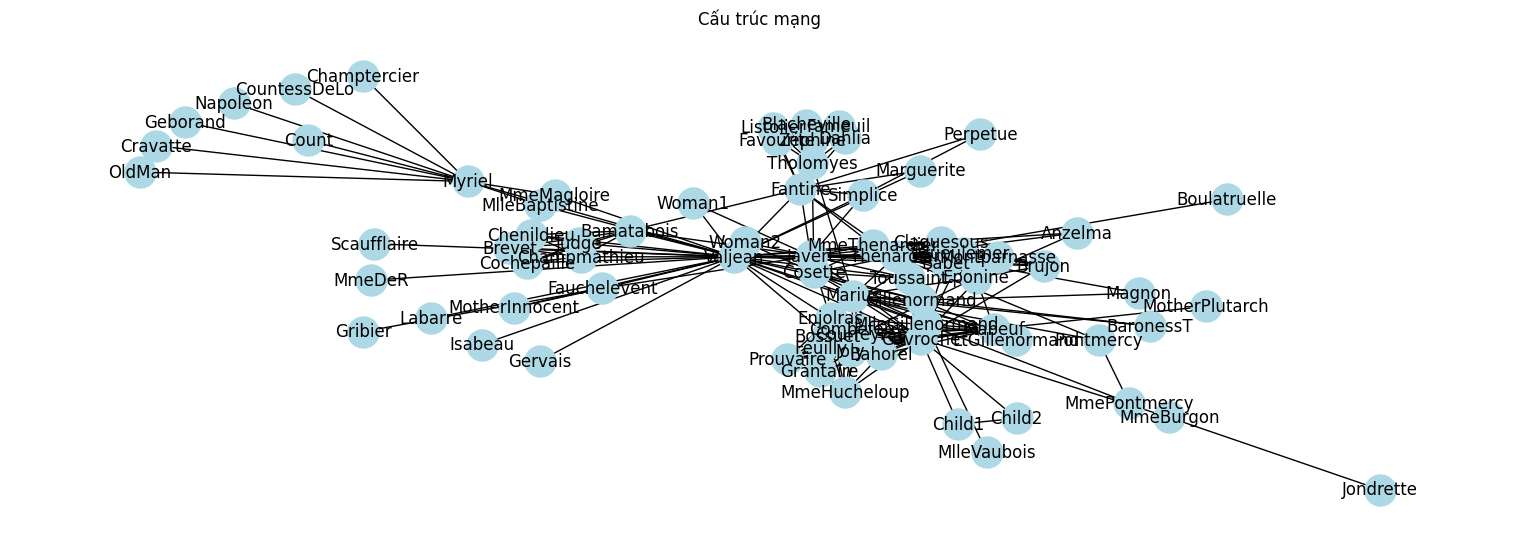

Train edges: 204
Test positive edges: 50
Test negative edges: 50

Bảng so sánh kết quả cho các phương pháp:
                    Method     AUC  Accuracy  Precision  Recall  F1-score
0         Common Neighbors  0.9430       0.8   0.734375    0.94  0.824561
1      Jaccard Coefficient  0.8944       0.8   0.734375    0.94  0.824561
2              Adamic-Adar  0.9444       0.8   0.734375    0.94  0.824561
3  Preferential Attachment  0.7976       0.5   0.500000    0.94  0.652778


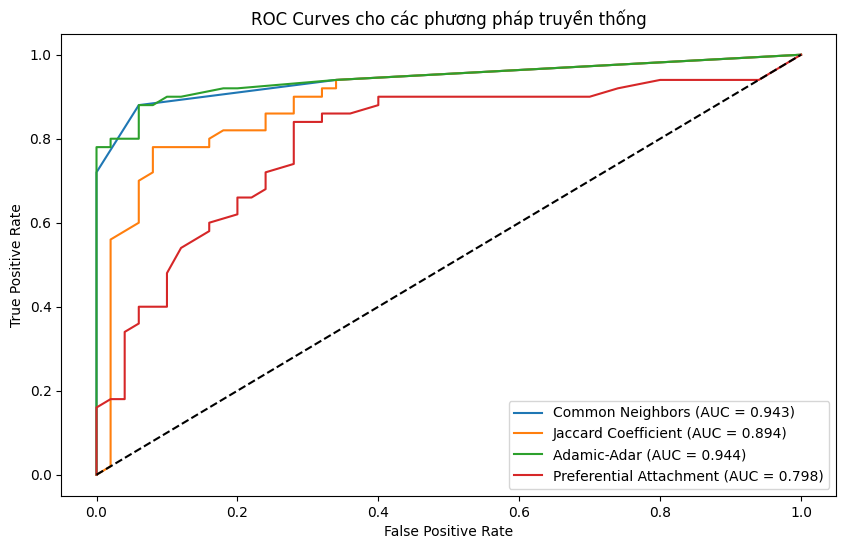


Kết quả AUC cho các phương pháp:
Common Neighbors: 0.943
Jaccard Coefficient: 0.894
Adamic-Adar: 0.944
Preferential Attachment: 0.798

Bảng kết quả mở rộng với Random Forest:
                    Method       AUC  Accuracy  Precision    Recall  F1-score
0         Common Neighbors  0.943000  0.800000   0.734375  0.940000  0.824561
1      Jaccard Coefficient  0.894400  0.800000   0.734375  0.940000  0.824561
2              Adamic-Adar  0.944400  0.800000   0.734375  0.940000  0.824561
3  Preferential Attachment  0.797600  0.500000   0.500000  0.940000  0.652778
4            Random Forest  0.954751  0.833333   0.833333  0.882353  0.857143


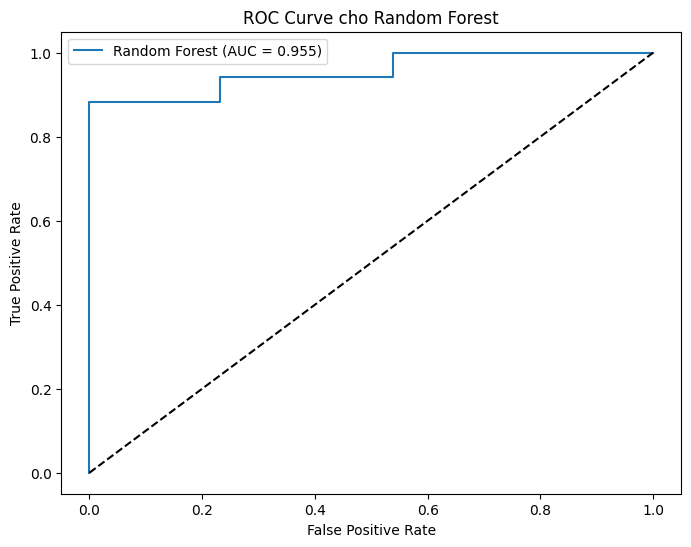

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class LinkPrediction:
    def __init__(self, dataset='karate'):
        """
        Khởi tạo với dataset đã cho.

        Parameters:
            dataset (str): Tên dataset ('karate', 'les', 'florentine')
        """
        if dataset == 'karate':
            self.G = nx.karate_club_graph()
        elif dataset == 'les':
            self.G = nx.les_miserables_graph()
        elif dataset == 'florentine':
            self.G = nx.florentine_families_graph()
        else:
            raise ValueError("Dataset không hợp lệ")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_ml(self):
        """Huấn luyện mô hình ML và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Tính các metric
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Tạo DataFrame mới cho Random Forest
        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        # Concatenate với kết quả cũ
        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)

        # Hiển thị bảng kết quả
        print("\nBảng kết quả mở rộng với Random Forest:")
        print(self.results_df)

        # Vẽ ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve cho Random Forest')
        plt.legend()
        plt.show()


    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(self.train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(self.train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]  # Dự đoán nhị phân

            # Tính các metric
            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng so sánh kết quả cho các phương pháp:")
        print(self.results_df)

        # Vẽ ROC Curves
        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_scores):.3f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves cho các phương pháp truyền thống')
        plt.legend()
        plt.show()

        print("\nKết quả AUC cho các phương pháp:")
        # Sử dụng results_df thay vì results để in kết quả AUC
        for _, row in self.results_df.iterrows():
            print(f"{row['Method']}: {row['AUC']:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm hoàn chỉnh."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()

if __name__ == "__main__":
    print("Chọn dataset:")
    print("1. Zachary's Karate Club")
    print("2. Les Miserables Network")
    print("3. Florentine Families Network")
    choice = input("Nhập lựa chọn (1-3): ")
    datasets = {'1': 'karate', '2': 'les', '3': 'florentine'}

    if choice in datasets:
        lp = LinkPrediction(dataset=datasets[choice])
        lp.run_experiment()
    else:
        print("Lựa chọn không hợp lệ!")


**Dataset 3: Florentine Families Network**
- Đồ thị gồm 15 nodes và 20 cạnh.
- Clustering coef = 0.16 cho thấy mạng có mức độ cụm thấp, các mối quan hệ chưa thực sự tạo thành nhiều nhóm kết nối chặt chẽ.
- Chỉ số Common Neighbors, Jaccard Coefficient, Adamic-Adar, Preferential Attachment đều thấp hơn mức baseline cho thấy kết quả dự đoán kém các cạnh có khả năng xuất hiện cùng nhau.
- Accuracy, Precision, Recal, F1-score rất thấp cho thấy mô hình dự đoán hầu hết sai.
- Random Forest đạt AUC = 1 ==> Dự đoán đúng tất cả các cạnh. Tuy nhiên bộ dữ liệu quá nhỏ có thể gây ra overfitting.
- Precision và Recall bằng 0 cho thấy mô hình dự đoán sai hoàn toàn các cạnh thực sự tồn tại trong tập test.


**Dataset 2: Les Miserables Network**
- Mạng gồm 77 nodes và 254 edges
- Clustering coef = 0.573 trung bình cao cho thấy các nodes có xu hướng kết nối kha khá tốt, hình thành kha khá cụm tam giác.
- Adamic-Adar, Common Neighbors là hai phương pháp hoạt động tốt nhất với AUC > 0.94 và các chỉ số khác đạt hiệu suất cao. Tiếp theo là tới Jaccard coef. Cuối cùng là Preferential Attachment cho chỉ số thấp.
- Random Forest đạt AUC = 0.955, cao hơn tất cả các phương pháp trên cho thấy khả năng phân biệt tốt giữa các cạnh tồn tại và không tồn tại trong tập test.
